In [1]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
import matplotlib.pyplot as plt

In [2]:
import gym
import os
import numpy as np
from pyvirtualdisplay import Display

from cartpole.config import get_cfg_defaults
from cartpole.utils import ReplayMemory, screen_to_state
from cartpole.model import DQN



cfg = get_cfg_defaults()

devices = ",".join(str(i) for i in cfg.SYSTEM.DEVICES)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = devices

In [3]:
"""
If you want to access the behind-the.scenes dynamics of a specific environment, 
then you use the unwrapped property.
"""
display = Display(visible=0, size=cfg.SYSTEM.VIRTUAL_SCREEN)
display.start()
env = gym.make("CartPole-v0").unwrapped


In [4]:
#policy_net = DQN(2)
#target_net = DQN(2)

In [5]:
from tensorflow.python.keras import models, layers

class Brain(models.Model):
    def __init__(self, policy_net, target_net, gamma):
        super(Brain, self).__init__()
        self.policy_net = policy_net
        self.target_net = target_net
        self.loss_layer = LossLayer(name="TDerror")
        self.gamma = gamma
        
        self.policy_net.trainable = False
        
    def call(self, x):
        state, action, next_state, reward, done = x
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        action = tf.convert_to_tensor(action, dtype=tf.float32)
        next_state = tf.convert_to_tensor(next_state, dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32)
        done = tf.convert_to_tensor(done, dtype=tf.float32)
        
        bz = K.shape(state)[0] # state.shape.as_list()[0]
        target = reward + (1-done) * self.gamma * tf.gather_nd(self.target_net(next_state), 
                                                               tf.stack((tf.range(bz), 
                                                                         tf.cast(tf.argmax(self.policy_net(state), 
                                                                                           axis=1), dtype=tf.int32)), axis=1))
        estimate = tf.gather_nd(self.policy_net(state), 
                                tf.stack((tf.range(bz), 
                                          tf.cast(action, dtype=tf.int32) ), axis=1))
        loss = self.loss_layer([target, estimate])
        """
        loss = tf.keras.losses.MSE(target, estimate)
        self.add_loss(loss)
        """
        return target, estimate
    
class LossLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(LossLayer, self).__init__(**kwargs)
        
    def call(self, inputs):
        print(inputs[0])
        print(inputs[1])
        loss = K.square(K.mean(inputs[0]-inputs[1]))
        self.add_loss(loss)
        return inputs

In [42]:
#policy_net.build(input_shape=(1, 60,60,3))
#target_net.build(input_shape=(1, 60,60,3))
#x = policy_net.weights[0]


#for i,j in zip(policy_net.layers, target_net.layers):
#    i.set_weights(j.get_weights())



In [6]:
# agent.py
from cartpole.utils import Transition
import tensorflow as tf
from tensorflow.python.keras import backend as K
import random


class DqnAgent():
    def __init__(self, input_shape=(128, 128, 3), 
                 action_space=2, 
                 soft_update_ratio=0.01,
                 gamma=0.99,
                 memory=None,
                 eps_start=0.9, eps_end=0.05, eps_decay=200,
                 batch_size=128,
                 fully_random_mode=False,
                 ):
        self.action_space = action_space
        self.soft_update_ratio = soft_update_ratio
        self.gamma = gamma
        self.memory = memory
        self.eps = eps_start
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.fully_random_mode = fully_random_mode
        
        K.clear_session()
        self.policy_net = DQN(action_space) # action giver
        self.target_net = DQN(action_space) # action learner
        self.policy_net.build(input_shape=(1,)+input_shape)
        self.target_net.build(input_shape=(1,)+input_shape)
        #self._soft_update() # sync weights at begining
        
        self.step_done = 0
    
    def act(self, state):
        """ Decide to random act or follow policy"""
        dice = random.random()
        if (dice < self.eps) or (self.fully_random_mode):
            # Random act
            action = np.random.choice(self.action_space)
        else:
            # Follow policy
            action = self.policy_net.predict(state)
        self._update_eps()
        
        return action
    
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        
        transition = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transition))
    
    def _soft_update(self):
        [j.set_weights(i.get_weights() + j.get_weights()) \
         for i,j in zip(self.policy_net.layers, self.target_net.layers)]
        
    def _update_eps(self):
        self.eps = self.eps_end + (self.eps_start - self.eps_end)*np.exp(-1.*self.step_done/self.eps_decay)
        self.step_done += 1
            

In [7]:
memory = ReplayMemory(capacity=10000)
agent = DqnAgent(action_space=env.action_space.n, gamma=cfg.AGENT.GAMMA, memory=memory,
                 eps_start=cfg.AGENT.EPS_START, eps_end=cfg.AGENT.EPS_END, eps_decay=cfg.AGENT.EPS_DECAY,
                 batch_size=cfg.AGENT.BATCH_SIZE, 
                 input_shape=cfg.MODEL.INPUT_SIZE,
                 fully_random_mode=True,
                 )

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
#cfg.AGENT.NUM_EPISODE
for i_episode in range(2):
    env.reset()
    last_screen = screen_to_state(env, target_size=cfg.MODEL.INPUT_SIZE[:2])
    current_screen = screen_to_state(env, target_size=cfg.MODEL.INPUT_SIZE[:2])
    state = current_screen - last_screen
    
    for t_counter in range(cfg.AGENT.MAX_T):
        action = agent.act(state)
        
        vector_state, reward, is_done, _ = env.step(action)
        
        last_screen = current_screen
        current_screen = screen_to_state(env, target_size=cfg.MODEL.INPUT_SIZE[:2])
        if not is_done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        memory.push(state, action, next_state, reward, is_done)
        state = next_state
        
        # Train the model
        agent.learn()
        
        if is_done:
            break

In [31]:
m = agent.memory.sample(4)

In [32]:
b = Transition(*zip(*m))

In [76]:
s = tf.Variable(np.array(b.state), dtype=tf.float32)
a = tf.Variable(np.array(b.action), dtype=tf.float32)
sn = tf.Variable(np.array(b.next_state), dtype=tf.float32)
r = tf.Variable(np.array(b.reward), dtype=tf.float32)
d =  tf.Variable(np.array(b.done)*1, dtype=tf.float32)

In [54]:
new_brain = Brain(policy_net=agent.policy_net, target_net=agent.target_net, gamma=0.9)
optim = tf.keras.optimizers.Adam()

In [46]:
def compute_loss(y_true, y_pred):
    return K.square(K.mean(y_true-y_pred))

In [55]:
new_brain.total_loss = 0
new_brain.compile(optimizer=optim, loss=None)

In [81]:
"""
# Not implementedError ...
with tf.GradientTape() as tape:
    loss = new_brain([np.array(b.state), 
                      np.array(b.action), 
                      np.array(b.next_state),
                      np.array(b.reward), 
                      np.array(b.done)*1])
grads = tape.gradient(loss, new_brain.trainable_variables)
""" 
#new_brain.summary()


In [60]:
target, estimate = new_brain(batch)
loss = compute_loss(target, estimate)

Tensor("brain_3_2/add:0", shape=(4,), dtype=float32)
Tensor("brain_3_2/GatherNd_1:0", shape=(4,), dtype=float32)


In [63]:
grads = tf.gradients(loss, new_brain.trainable_variables)

In [52]:
batch = [np.array(b.state), 
         np.array(b.action), 
         np.array(b.next_state),
         np.array(b.reward), 
         np.array(b.done)*1]
new_brain.train_on_batch(batch)

InvalidArgumentError: You must feed a value for placeholder tensor 'output_2_target' with dtype float and shape [?]
	 [[{{node output_2_target}}]]

In [53]:
new_brain.losses

[<tf.Tensor 'TDerror_1/Square:0' shape=() dtype=float32>]

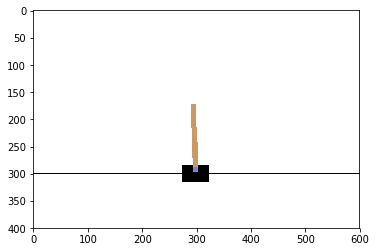

In [47]:
import matplotlib.pyplot as plt

plt.imshow(im)
plt.show()

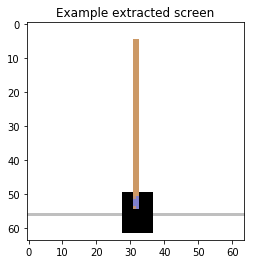

In [8]:
env.reset()
plt.figure()
plt.imshow(screen_to_state(env))
plt.title('Example extracted screen')
plt.show()